 > ### [예제 4] 다른종류의 IMDB를 활용한 영화 후기 분석

In [1]:
!pip install tensorflow_datasets 

import tensorflow as tf
import tensorflow_datasets as tfds

> ### Load IMDB Dataset


In [2]:
# 다운로드 시간 오래걸림, 차단된 경우 실행되지 않을 수 있음

dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_examples, test_examples = dataset['train'], dataset['test']

encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteEVONWP/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteEVONWP/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteEVONWP/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.
Vocabulary size: 8185


> ### 학습을 위한 데이터처리

In [3]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [4]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE, padded_shapes=([None],[])))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE,  padded_shapes=([None],[])))

In [5]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE))

## Create the model

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [7]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [8]:
%%time
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 44s 114ms/step - loss: 0.6498 - accuracy: 0.5597 - val_loss: 0.5147 - val_accuracy: 0.7099
Epoch 2/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3430 - accuracy: 0.8545 - val_loss: 0.3362 - val_accuracy: 0.8651
Epoch 3/10
391/391 [==============================] - 44s 114ms/step - loss: 0.2454 - accuracy: 0.9052 - val_loss: 0.3301 - val_accuracy: 0.8693
Epoch 4/10
391/391 [==============================] - 44s 114ms/step - loss: 0.2104 - accuracy: 0.9214 - val_loss: 0.3300 - val_accuracy: 0.8734
Epoch 5/10
391/391 [==============================] - 45s 114ms/step - loss: 0.1814 - accuracy: 0.9340 - val_loss: 0.3393 - val_accuracy: 0.8745
Epoch 6/10
391/391 [==============================] - 45s 114ms/step - loss: 0.1586 - accuracy: 0.9437 - val_loss: 0.3747 - val_accuracy: 0.8698
Epoch 7/10
391/391 [==============================] - 44s 114ms/step - loss: 0.1447 - accuracy: 0.9491 - val_loss: 0.3674 - val_ac

> ### 모델 평가

In [9]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 18s 45ms/step - loss: 0.4980 - accuracy: 0.8526
Test Loss: 0.4979906976222992
Test Accuracy: 0.8525599837303162


> ### Plot

In [10]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

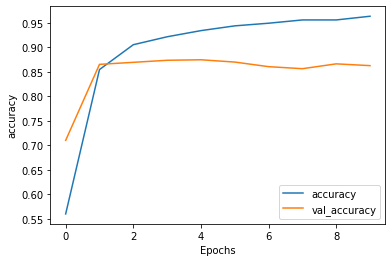

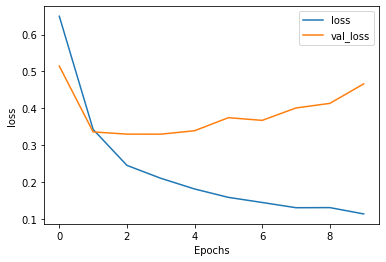

In [11]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

> ### Prediction

In [12]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [13]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [14]:
  line = "This is my life movie. The great showman ost cry hundreds of thousands of times"
  y = sample_predict(line,pad=False)
  print(float(y))  

1.2356103658676147
